Install and import all the necessary packages:

In [7]:
!pip install astropy
!pip install astroplan

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from datetime import datetime
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_moon, get_body, get_sun, Angle
import astroplan

Upload text file where all the stars are (downloaded from https://simbad.cds.unistra.fr/simbad/sim-fsam where Vmag is less than 6.5)

In [9]:
file_path = 'sim-sam.txt'

columns = ["#", "identifier", "typ", "coord1", "Mag_U", "Mag_B", "Mag_V", "Mag_R", "Mag_I", "spec_type", "#bib", "#not"]

df = pd.read_table(file_path, sep='|', skiprows=9, header=None, names=columns, skipinitialspace=True, engine='python')
df.head()

df[['RA', 'Dec']] = df['coord1'].str.extract(r'([+-]?\d+ \d+ \d+\.\d+) ([+-]?\d+ \d+ \d+\.\d+)')

def ra_to_hms(ra_str):
    if pd.notna(ra_str):
        parts = ra_str.split()
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = float(parts[2])
        ra_in_hours = hours%24*15 + minutes/60*15 + seconds/3600*15
        return ra_in_hours
    else:
        return None

df['RA'] = df['RA'].apply(ra_to_hms)

def dec_to_dms(dec_str):
    if pd.notna(dec_str):
        sign = -1 if dec_str.startswith('-') else 1
        parts = dec_str.lstrip('-').split()
        degrees = int(parts[0])
        minutes = int(parts[1])
        seconds = float(parts[2])
        dec_in_degrees = sign * (degrees + minutes/60 + seconds/3600)
        return dec_in_degrees
    else:
        return None

df['Dec'] = df['Dec'].apply(dec_to_dms)

df

,#,identifier,typ,coord1,Mag_U,Mag_B,Mag_V,Mag_R,Mag_I,spec_type,#bib,#not,RA,Dec
0,1,HD 200253,*,21 01 12.8647634688 +36 01 33.642578532,~,7.000,5.997,~,~,G5III,28,0,315.303603,36.026012
1,2,* tau Cyg,dS*,21 14 47.49252 +38 02 43.1441,4.140,4.120,3.730,3.38,3.14,F2IV,281,0,318.697885,38.045318
2,3,* 61 Cyg A,BY*,21 06 53.9395895022 +38 44 57.902349973,7.50,6.39,5.210,4.19,3.54,K5V,1029,0,316.724748,38.749417
3,4,* sig Cyg,sg*,21 17 24.9524404 +39 23 40.852798,3.98,4.37,4.240,4.06,3.92,A0Ia,265,0,319.353969,39.394681
4,5,V* V1334 Cyg,cC*,21 19 22.1791528656 +38 14 14.868825648,~,6.364,5.882,~,~,F1II+B7.0V,189,0,319.842413,38.237464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5114,5115,HD 40369A,*,05 58 53.233857 +12 48 29.75811,~,7.19,5.970,~,~,~,0,0,89.721808,12.808266
5115,5116,HD 39007A,*,05 50 02.6857362158 +09 52 16.373676115,~,6.82,5.860,~,~,~,1,0,87.511191,9.871215
5116,5117,HD 25330A,*,04 01 46.137104 +09 59 52.86178,~,5.80,5.810,~,~,~,0,0,60.442238,9.998017
5117,5118,HD 104878A,*,12 04 38.885690 -68 19 44.08056,~,5.48,5.520,~,~,~,0,0,181.162024,-68.328911


In [11]:
%reset_selective -f latitude
%reset_selective -f longitude
%reset_selective -f observation_time

latitude = 45.484264 # fixed latitude

if 'latitude' in locals():
    if latitude < -90 or latitude > 90:
        raise ValueError("Latitude must be between -90 and 90 degrees.")
        
if 'latitude' not in locals():
    while True:
        try:
            latitude = float(input("Enter your latitude: "))
            if -90 < latitude < 90:
                break
            else:
                print("Invalid input. Latitude must be between -90 and 90.")
        except ValueError:
            print("Invalid input. Please enter a numeric value for latitude.")

            
longitude = 15.96223 # fixed longitude

if 'longitude' in locals():
    if longitude < -180 or longitude > 180:
        raise ValueError("Longitude must be between -180 and 180 degrees (negative is western hemisphere, positive is eastern).")
 
if 'longitude' not in locals():
    while True:
        try:
            longitude = float(input("Enter your longitude: "))
            if -180 < longitude < 180:
                break
            else:
                print("Invalid input. Longitude must be between -180 and 180 (negative is western hemisphere, positive is eastern).")
        except ValueError:
            print("Invalid input. Please enter a numeric value for longitude.")


observation_time = Time("2024-02-20 21:00:00") # fixed observation time in UTC            
            
if 'observation_time' not in locals():            
    while True:
        date_time = input("Enter date and time in UTC (YYYY-MM-DD HH:MM format): ")
        date_time_pattern = re.compile(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$')
        if date_time_pattern.match(date_time):
            year, month, day, hour, minute = map(int, date_time.split()[0].split('-') + date_time.split()[1].split(':'))
            if (1 <= month <= 12 and
                1 <= day <= 31 and
                0 <= hour <= 23 and
                0 <= minute <= 59):
                break
            else:
                print("Invalid input. Please enter a valid date and time.")
        else:
            print("Invalid input. Please enter a date and time in the YYYY-MM-DD HH:MM format.")
    date_object = datetime.strptime(date_time, '%Y-%m-%d %H:%M')
    observation_time = Time(date_object) 


observer_location = EarthLocation(lat=latitude*u.deg, lon=longitude*u.deg)
star_coords = SkyCoord(ra=df['RA'].values*u.deg, dec=df['Dec'].values*u.deg)
altaz = star_coords.transform_to(AltAz(obstime=observation_time, location=observer_location))
df['az'] = altaz.az[:].degree
df['alt'] = altaz.alt[:].degree
df.head()

/home/codespace/.python/current/lib/python3.10/site-packages/erfa/core.py:4642: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/home/codespace/.python/current/lib/python3.10/site-packages/erfa/core.py:19026: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/home/codespace/.python/current/lib/python3.10/site-packages/erfa/core.py:4058: RuntimeWarning: invalid value encountered in atioq
  aob, zob, hob, dob, rob = ufunc.atioq(ri, di, astrom)


,#,identifier,typ,coord1,Mag_U,Mag_B,Mag_V,Mag_R,Mag_I,spec_type,#bib,#not,RA,Dec,az,alt
0,1,HD 200253,*,21 01 12.8647634688 +36 01 33.642578532,~,7.000,5.997,~,~,G5III,28,0,315.303603,36.026012,348.411550,-7.386598
1,2,* tau Cyg,dS*,21 14 47.49252 +38 02 43.1441,4.140,4.120,3.730,3.38,3.14,F2IV,281,0,318.697885,38.045318,346.137558,-4.875580
2,3,* 61 Cyg A,BY*,21 06 53.9395895022 +38 44 57.902349973,7.50,6.39,5.210,4.19,3.54,K5V,1029,0,316.724748,38.749417,347.800601,-4.501779
3,4,* sig Cyg,sg*,21 17 24.9524404 +39 23 40.852798,3.98,4.37,4.240,4.06,3.92,A0Ia,265,0,319.353969,39.394681,345.933395,-3.446822
4,5,V* V1334 Cyg,cC*,21 19 22.1791528656 +38 14 14.868825648,~,6.364,5.882,~,~,F1II+B7.0V,189,0,319.842413,38.237464,345.299801,-4.488215


Add coordinates of visible Solar System bodies:

In [ ]:
print('Coordinates of Solar System bodies:')

sun_altaz = get_sun(observation_time).transform_to(AltAz(obstime=observation_time, location=observer_location))
sun_altitude_deg = sun_altaz.alt.degree
sun_azimuth_deg = sun_altaz.az.degree

print("\nSun altitude: ", sun_altitude_deg, '° (', sun_altaz.alt.to_string(unit=u.degree),')', sep='')
print("Sun azimuth: ", sun_azimuth_deg, '° (', sun_altaz.az.to_string(unit=u.degree),')', sep='')

moon_altaz = get_body('moon', observation_time, observer_location).transform_to(AltAz(obstime=observation_time, location=observer_location))
moon_altitude_deg = moon_altaz.alt.degree
moon_azimuth_deg = moon_altaz.az.degree

print("\nMoon altitude: ", moon_altitude_deg, '° (', moon_altaz.alt.to_string(unit=u.degree),')', sep='')
print("Moon azimuth: ", moon_azimuth_deg, '° (', moon_altaz.az.to_string(unit=u.degree),')', sep='')

mercury_altaz = get_body('mercury', observation_time, observer_location).transform_to(AltAz(obstime=observation_time, location=observer_location))
mercury_altitude_deg = mercury_altaz.alt.degree
mercury_azimuth_deg = mercury_altaz.az.degree

print("\nMercury altitude: ", mercury_altitude_deg, '° (', mercury_altaz.alt.to_string(unit=u.degree),')', sep='')
print("Mercury azimuth: ", mercury_azimuth_deg, '° (', mercury_altaz.az.to_string(unit=u.degree),')', sep='')

venus_altaz = get_body('venus', observation_time, observer_location).transform_to(AltAz(obstime=observation_time, location=observer_location))
venus_altitude_deg = venus_altaz.alt.degree
venus_azimuth_deg = venus_altaz.az.degree

print("\nVenus altitude: ", venus_altitude_deg, '° (', venus_altaz.alt.to_string(unit=u.degree),')', sep='')
print("Venus azimuth: ", venus_azimuth_deg, '° (', venus_altaz.az.to_string(unit=u.degree),')', sep='')

mars_altaz = get_body('mars', observation_time, observer_location).transform_to(AltAz(obstime=observation_time, location=observer_location))
mars_altitude_deg = mars_altaz.alt.degree
mars_azimuth_deg = mars_altaz.az.degree

print("\nMars altitude: ", mars_altitude_deg, '° (', mars_altaz.alt.to_string(unit=u.degree),')', sep='')
print("Mars azimuth: ", mars_azimuth_deg, '° (', mars_altaz.az.to_string(unit=u.degree),')', sep='')

jupiter_altaz = get_body('jupiter', observation_time, observer_location).transform_to(AltAz(obstime=observation_time, location=observer_location))
jupiter_altitude_deg = jupiter_altaz.alt.degree
jupiter_azimuth_deg = jupiter_altaz.az.degree

print("\nJupiter altitude: ", jupiter_altitude_deg, '° (', jupiter_altaz.alt.to_string(unit=u.degree),')', sep='')
print("Jupiter azimuth: ", jupiter_azimuth_deg, '° (', jupiter_altaz.az.to_string(unit=u.degree),')', sep='')

saturn_altaz = get_body('saturn', observation_time, observer_location).transform_to(AltAz(obstime=observation_time, location=observer_location))
saturn_altitude_deg = saturn_altaz.alt.degree
saturn_azimuth_deg = saturn_altaz.az.degree

print("\nSaturn altitude: ", saturn_altitude_deg, '° (', saturn_altaz.alt.to_string(unit=u.degree),')', sep='')
print("Saturn azimuth: ", saturn_azimuth_deg, '° (', saturn_altaz.az.to_string(unit=u.degree),')', sep='')

uranus_altaz = get_body('uranus', observation_time, observer_location).transform_to(AltAz(obstime=observation_time, location=observer_location))
uranus_altitude_deg = uranus_altaz.alt.degree
uranus_azimuth_deg = uranus_altaz.az.degree

print("\nUranus altitude: ", uranus_altitude_deg, '° (', uranus_altaz.alt.to_string(unit=u.degree),')', sep='')
print("Uranus azimuth: ", uranus_azimuth_deg, '° (', uranus_altaz.az.to_string(unit=u.degree),')', sep='')

Coordinates of Solar System bodies:

Sun altitude: -45.67353030279122° (-45d40m24.70909005s)
Sun azimuth: 311.02806759410214° (311d01m41.04333877s)

Moon altitude: 70.13491687999955° (70d08m05.700768s)
Moon azimuth: 199.25923595021086° (199d15m33.24942076s)

Mercury altitude: -51.73558897167352° (-51d44m08.12029802s)
Mercury azimuth: 314.0769706188482° (314d04m37.09422785s)

Venus altitude: -63.26714991248076° (-63d16m01.73968493s)
Venus azimuth: 346.51610416645246° (346d30m57.97499923s)

Mars altitude: -63.603415845847636° (-63d36m12.29704505s)
Mars azimuth: 344.5322860004948° (344d31m56.22960178s)

Jupiter altitude: 14.3450695688568° (14d20m42.25044788s)
Jupiter azimuth: 275.3182147081557° (275d19m05.57294936s)

Saturn altitude: -40.70512390999729° (-40d42m18.44607599s)
Saturn azimuth: 303.75424251837944° (303d45m15.27306617s)

Uranus altitude: 23.16114929148773° (23d09m40.13744936s)
Uranus azimuth: 271.48816889482737° (271d29m17.40802138s)


Plot the sky:

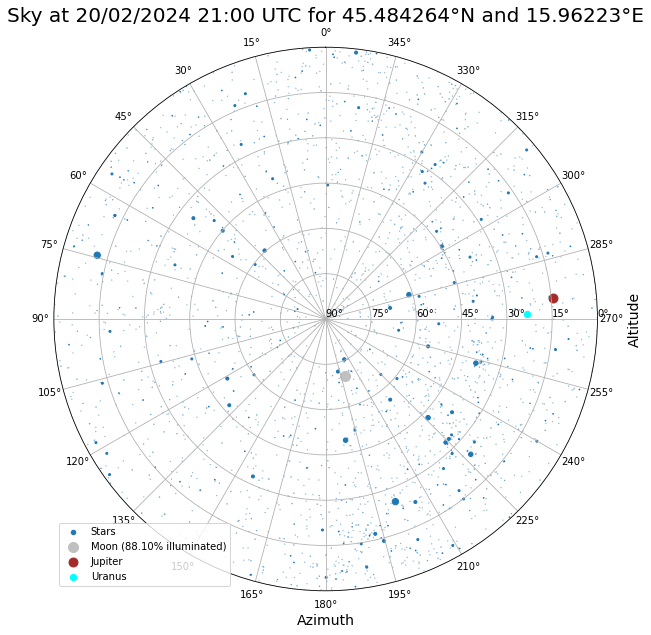

In [ ]:
def get_point_size(mag_v): # size of the stars
    if mag_v < 0:
        return 40
    if mag_v < 1:
        return 20
    elif 1 <= mag_v < 2:
        return 9
    elif 1 <= mag_v < 3:
        return 4
    elif 1 <= mag_v < 4:
        return 0.5
    elif 1 <= mag_v < 5:
        return 0.1
    else:
        return 0.05
    
df['point_size'] = df['Mag_V'].apply(get_point_size)

time = Time(observation_time, format='iso', scale='utc')
moon_illumination = astroplan.moon_illumination(time)
moon_illumination_percentage = moon_illumination * 100

fig, axs = plt.subplots(1, 1, figsize=(15,10), subplot_kw={'projection': 'polar'})

df_visible = df[df['alt'] >= 0]

axs.set_rlim(bottom=90, top=0)
axs.scatter(np.radians(df_visible['az']), df_visible['alt'], s=df_visible['point_size'], label='Stars')#, label=df_north['identifier'])

if sun_altaz.alt > 0:    
    axs.scatter(np.radians(sun_altaz.az), sun_altaz.alt, s=400, label='Sun', color='yellow')
if moon_altaz.alt > 0:
    axs.scatter(np.radians(moon_altaz.az), moon_altaz.alt, s=100, label=f'Moon ({moon_illumination_percentage:.2f}% illuminated)', color='silver')
if mercury_altaz.alt > 0:    
    axs.scatter(np.radians(mercury_altaz.az), mercury_altaz.alt, s=40, label='Mercury', color='lightsteelblue')
if venus_altaz.alt > 0:    
    axs.scatter(np.radians(venus_altaz.az), venus_altaz.alt, s=40, label='Venus', color='lightgreen')  
if mars_altaz.alt > 0:    
    axs.scatter(np.radians(mars_altaz.az), mars_altaz.alt, s=40, label='Mars', color='red')
if jupiter_altaz.alt > 0:    
    axs.scatter(np.radians(jupiter_altaz.az), jupiter_altaz.alt, s=80, label='Jupiter', color='brown')
if saturn_altaz.alt > 0:    
    axs.scatter(np.radians(saturn_altaz.az), saturn_altaz.alt, s=60, label='Saturn', color='sandybrown')
if uranus_altaz.alt > 0:    
    axs.scatter(np.radians(uranus_altaz.az), uranus_altaz.alt, s=40, label='Uranus', color='cyan')

axs.set_theta_zero_location('N')
axs.set_theta_direction(1)
axs.set_rlabel_position(-90)
plt.legend()

observation_time_str = observation_time.strftime('%d/%m/%Y %H:%M')
if latitude > 0:
    lat_str = 'N'
else:
    lat_str = 'S'
if longitude > 0:
    lon_str = 'E'
else:
    lon_str = 'W'
    
axs.set_xlabel('Azimuth', fontsize=14)
axs.set_ylabel('Altitude', rotation=90, labelpad=30, fontsize=14)
axs.yaxis.set_label_position('right') 

declination_ticks = np.arange(90, -10, -15)
declination_tick_labels = [f"{declination}°" for declination in declination_ticks]
axs.set_yticks(declination_ticks)
axs.set_yticklabels(declination_tick_labels)

axs.set_xticks(np.radians(np.arange(0, 360, 15)))
        
axs.set_title(f'Sky at {observation_time_str} UTC for {np.abs(latitude)}°{lat_str} and {np.abs(longitude)}°{lon_str}', fontsize=20)
plt.show()